In [6]:
import os, sys
import numpy as np

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import matplotlib.pyplot as plt
from matplotlib import cm

import copy

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)

#### Load everything to plot
Here i am loading the results of an analysis correlating each voxel's beta weights with semantic categories (no encoding model used here, just raw data)

In [7]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

feature_type_list_long = ['semantic_discrim_raw_val_all']
feature_type_list = ['raw']
n_models = len(feature_type_list)

# getting info on the names of semantic categories
# choosing to negate one axis to make the plots more intuitive (?)
# but the signs are arbitrary
which_axes_negate = [1]
axes_to_do_partial = [0,2,3]
discrim_names, signed_names, n_levels = \
    load_feature_stats.load_partial_discrim_names(axes_to_do_partial, which_axes_negate)

n_discrim_types = len(signed_names);

# diff subjects will have diff numbers of voxels
max_voxels = 30000

partial_corrs = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))

noise_ceilings = np.zeros((n_subjects, max_voxels))

n_voxels_each_subj = np.zeros((n_subjects,),dtype=int)

min_samp=3;

for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(feature_type_list_long):

        # load the semantic selectivity results for each voxel
        out= load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False);
        assert(out['average_image_reps']==True)
        
        if fi==0:
            n_voxels = int(np.sum(out['voxel_mask']))
            n_voxels_each_subj[si] = n_voxels

        c_partial = copy.deepcopy(out['sem_partial_corrs']).T        
        assert(np.all(out['sem_partial_n_samp']>=min_samp))
        c_partial[which_axes_negate,:] *= (-1)
        partial_corrs[fi,:,si,0:n_voxels] = c_partial;
       
        noise_ceilings[si,0:n_voxels] = summary_plots.get_noise_ceiling(out)

#### Define ROIs

In [8]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

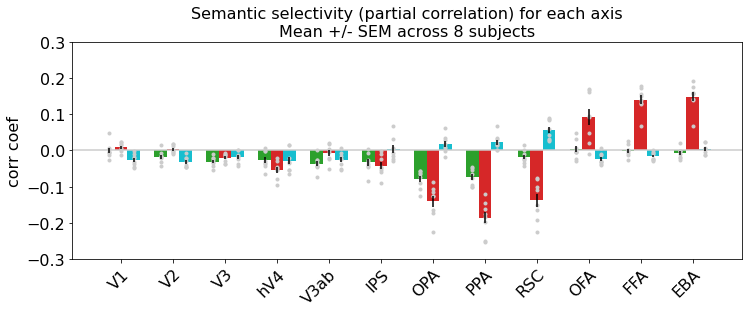

In [9]:
mm=0;

nc_thresh = 0.01

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si,0:n_voxels_each_subj[si]]
    vox2use = nc>nc_thresh
    vals = copy.deepcopy(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]])

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Semantic selectivity (partial correlation) for each axis\nMean +/- SEM across 8 subjects'

bw = 0.24;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = np.moveaxis(roi_mean_vals, [0,1,2], [1,2,0]), \
                                colors=colors, space=space, \
            xticklabels=roi_names, ylabel='corr coef', \
            ylim=[-0.3, 0.3], title=title, horizontal_line_pos=0,\
            legend_labels=signed_names, \
            legend_overlaid=False, legend_separate=False, \
            fig_size=(12,4))

fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
plt.savefig(fn2save)